#### I trained this notebook on kaggle because of GPU

In [51]:
# Main packages
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt

In [52]:
# Tensorflow-Keras packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [53]:
# Define parameters values
IMG_SIZE = (256, 256)
VALID_SPLIT = 0.3
BATCH_SIZE = 32
SEED = 42
PATH = "../input/indian-food-classification/Food Classification"

# Get train image with generator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Get validation image with generator
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 6269 files belonging to 20 classes.
Using 4389 files for training.
Found 6269 files belonging to 20 classes.
Using 1880 files for validation.


# Visualize the data

Let us take a look at what our data look like!

In [54]:
# Get class names
classes = train_ds.class_names
classes

['burger',
 'butter_naan',
 'chai',
 'chapati',
 'chole_bhature',
 'dal_makhani',
 'dhokla',
 'fried_rice',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa']

image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images

In [55]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None, 20)), types: (tf.float32, tf.float32)>

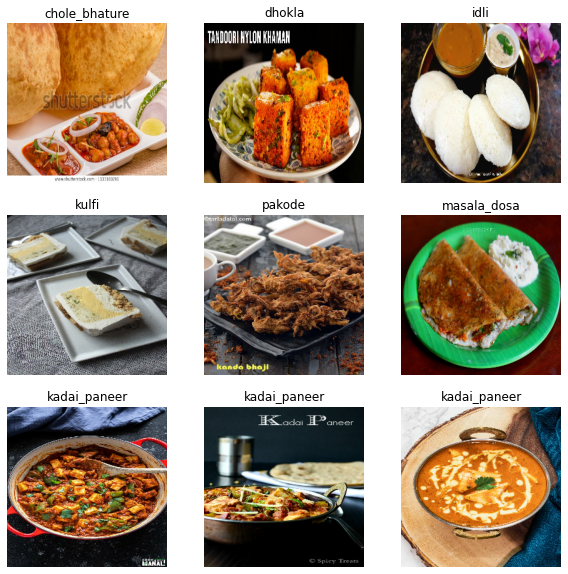

In [56]:
# visualise the images in a batch
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# Get a single batch from the dataset
for images, labels in train_ds.take(1):
    # Plot each image in the batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

In [57]:
# Data augmentation: kind of transformations
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

# Apply transformation to train data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Configure the dataset for performance

In [58]:
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Build a model


made the model from here
https://keras.io/examples/vision/image_classification_from_scratch/

In [59]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

print(IMG_SIZE + (3,))
model = make_model(input_shape=IMG_SIZE + (3,), num_classes=len(classes))

(256, 256, 3)


In [60]:
# Extend the hidden output if you want to see the model structure
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           sequential_1[0][0]               
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 64) 1792        rescaling_1[0][0]                
____________________________________________________________________________________________

# Train the model OR Load the mode
depending on the value of `ok`:
- `True`  : Train
- `False` : Load

In [62]:
ok = True

if ok:
    # Parameters
    EPOCHS = 20
    CALLBACK = [
        keras.callbacks.ModelCheckpoint("filepath='model.{epoch:02d}-{val_loss:.2f}.h5'"),
        keras.callbacks.EarlyStopping(patience=15)
    ]
    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    
    history = model.fit(
        augmented_train_ds,
        epochs=EPOCHS,
        callbacks=CALLBACK,
        validation_data=val_ds,
    )
    
else:
    model = keras.models.load_model('../input/indian-food-classification-keras-cnn/save_at_50.h5')

Epoch 1/20
138/138 [==============================] - 134s 922ms/step - loss: 2.3749 - categorical_accuracy: 0.2916 - val_loss: 4.8269 - val_categorical_accuracy: 0.0670
Epoch 2/20
138/138 [==============================] - 126s 897ms/step - loss: 2.0795 - categorical_accuracy: 0.3760 - val_loss: 5.4500 - val_categorical_accuracy: 0.0670
Epoch 3/20
138/138 [==============================] - 127s 898ms/step - loss: 1.8650 - categorical_accuracy: 0.4392 - val_loss: 3.8928 - val_categorical_accuracy: 0.1457
Epoch 4/20
138/138 [==============================] - 127s 895ms/step - loss: 1.7316 - categorical_accuracy: 0.4696 - val_loss: 3.1477 - val_categorical_accuracy: 0.3112
Epoch 5/20
138/138 [==============================] - 127s 898ms/step - loss: 1.6092 - categorical_accuracy: 0.5149 - val_loss: 2.6308 - val_categorical_accuracy: 0.3628
Epoch 6/20
138/138 [==============================] - 126s 898ms/step - loss: 1.5361 - categorical_accuracy: 0.5374 - val_loss: 2.4948 - val_categoric

In [63]:
# List all data in history
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


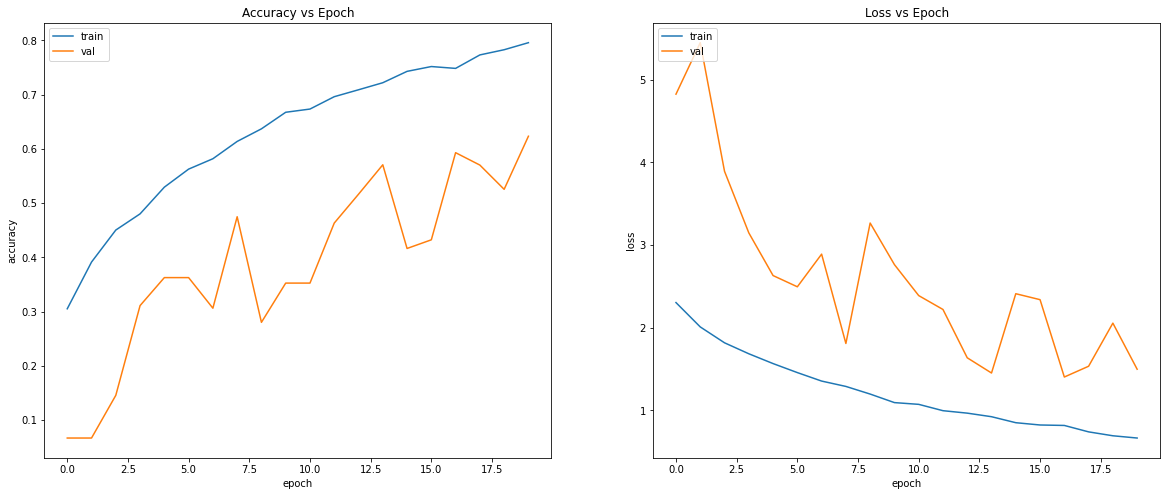

In [64]:
# Create a plot layout
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Summarize history for accuracy
ax[0].plot(history.history['categorical_accuracy'])
ax[0].plot(history.history['val_categorical_accuracy'])
ax[0].set_title('Accuracy vs Epoch')
ax[0].set(xlabel='epoch', ylabel='accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

# Summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

# Display plots
plt.show()

# Run inference on data

In [65]:
imgs = [
    "../input/indian-food-classification-test-images/burger.jpg",
    "../input/indian-food-classification-test-images/chai.jpeg",
    "../input/indian-food-classification-test-images/chapati.jpeg",
    "../input/indian-food-classification-test-images/dal_makhani.jpeg",
    "../input/indian-food-classification-test-images/samosa.jpg"
]

for img in imgs:
    try:
        # Load the image
        raw_img = keras.preprocessing.image.load_img(img, target_size=IMG_SIZE)
    except:
        continue
    
    # Conver to to numpy array
    img_array = keras.preprocessing.image.img_to_array(raw_img)
    
    # Reshaping
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    # Make predictions
    predictions = model.predict(img_array)
    series      = pd.Series(predictions[0], index=classes)
    
    # Get score
    proba      = np.max(predictions)
    pred_class = classes[np.argmax(predictions)]
    
    # Display results
    fig, ax = plt.subplots(1, 2, figsize=(24, 4))
    
    ax[0].imshow(raw_img)
    ax[0].title.set_text(f"This image may be {pred_class} at {round(proba * 100,2)}%")
    
    series.plot(kind='bar', ax=ax[1], color='green')
    ax[1].title.set_text("Probabilities")
    ax[1].tick_params(labelrotation=75)
    
    plt.show()